# Tutorial - Green Urban Scenarious
A demo of a minimal flow of GUS process.

For more advanced use cases, please see upcoming article. For more structured experiment and scenario analyis plese see model sepcification and code documentation within docs/ folder. 

In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 3
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json
import pprint
pp = pprint.PrettyPrinter(indent=1)
sns.set_theme()

## 0. Importing GUS modules

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.gus.models import Urban
from src.gus.utilities import get_raster_data

## 1. Initilisation

### 1.1 Importing data on site, tree populations, experiment parameters

In [4]:
import logging
logfile = os.path.join(module_path, 'outputs/gus.log')
logging.basicConfig(filename=logfile, format='%(asctime)s %(levelname)s %(message)s', level=logging.INFO)

# File that holds site/city other geolocated data and parameters
fname_config_site = os.path.join(module_path, 'src/gus/inputs/site.json')

# File that include tree species specific parameters
fname_config_allometrics = os.path.join(module_path, 'src/gus/inputs/allometrics.json')

# File that include individual tree data including their location on a 2D raster of the actual location
fname_data_trees = os.path.join(module_path, 'src/gus/inputs/trees.csv')

# File that holds experiment parameters
fname_scenario_params = os.path.join(module_path, 'src/gus/inputs/scenario.json')

In [5]:
f = open(fname_config_allometrics)
config_allometrics = json.loads(f.read())
#pp.pprint(config_allometrics)

In [6]:
f = open(fname_config_site)
config_site = json.loads(f.read())
pp.pprint(config_site)

{'area_impervious_in_m2': 500,
 'area_pervious_in_m2': 500,
 'area_total_in_m2': 1000,
 'area_tree_density_per_hectare': 400,
 'project_site_type': 'park',
 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}}


In [7]:
df_pop = pd.read_csv(fname_data_trees)
df_pop.tail()

,id,species,dbh,height,condition,xpos,ypos
95,96,conifer,13.871098,3.303454,good,17,4
96,97,conifer,12.561324,3.165903,good,17,5
97,98,conifer,13.651542,3.436859,good,17,6
98,99,conifer,12.610441,3.195499,good,17,3
99,100,conifer,12.491068,3.467151,excellent,17,7


In [8]:
f = open(fname_scenario_params)
scenario_params = json.loads(f.read())
pp.pprint(scenario_params)

{'is_crownsunexposure_fixed': 1,
 'maintenance_scope': 2,
 'time_horizon_years': 50}


### 1.2 Creating a digital twin of the site

In [9]:
site = Urban(df_pop,
            fname_config_allometrics,
            fname_config_site,
            scenario_params)

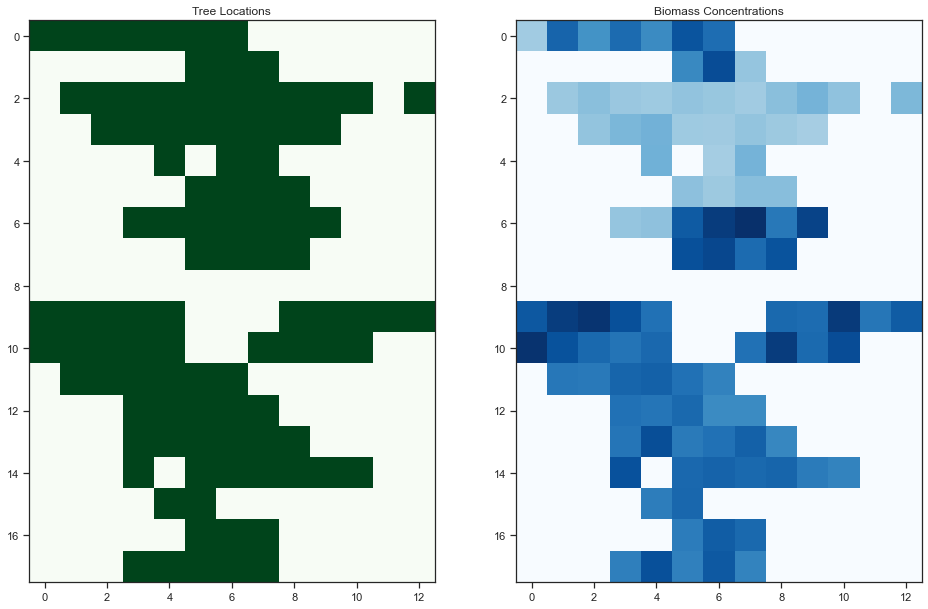

In [10]:
initial_locations = get_raster_data(site, counts=True)
initial_biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,12))
plt.subplot(121)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Tree Locations")
plt.subplot(122)
plt.title("Biomass Concentrations")
plt.imshow(initial_biomass, cmap='Blues')
#plt.colorbar(label = 'Biomass - Kg')
plt.show()

## 2. Running the scenario

In [11]:
for i in range(scenario_params['time_horizon_years']):
    site.step()

## 3. Analysis

### 3.1 Individual tree level inspections 

In [12]:
# Tree level individual variables
fname_output_trees = os.path.join(module_path, 'outputs/trees_yearly.json')
df_out_tree = site.datacollector.get_agent_vars_dataframe()
df_out_tree.to_csv(fname_output_trees, index=True)
df_out_tree.tail()

species        dbh    height    crownH    crownW  \
Step AgentID                                                     
50   153      conifer  16.846444  9.979643  5.729985  3.749421   
     154       decidu  12.792370  9.948122  5.227545  4.527505   
     155       decidu  11.128713  9.223042  4.785981  4.144372   
     156      conifer  10.069305  6.372897  4.037531  2.531315   
     157      conifer   9.383913  5.984263  3.855833  2.402785   

              canopy_overlap       cle  condition   dieback     biomass  \
Step AgentID                                                              
50   153            0.078119  0.960677       good  0.010527  125.687013   
     154            0.692100  0.651723  excellent  0.002000   73.317615   
     155            0.631761  0.670765  excellent  0.001000   53.586615   
     156            0.011598  0.993260  excellent  0.006897   35.693402   
     157            0.000000  0.560000  excellent  0.009876   30.040176   

                   seq     carbon  deroot  detrunk   mulched  burnt  \
Step AgentID                                                          
50   153      6.341107  62.843506     0.0      0.0  0.033077    0.0   
     154      5.650113  36.658808     0.0      0.0  0.003666    0.0   
     155      4.848804  26.793307     0.0      0.0  0.001340    0.0   
     156      3.054660  17.846701     0.0      0.0  0.006155    0.0   
     157      0.000000  15.020088     0.0      0.0  0.000000    0.0   

             coordinates  
Step AgentID              
50   153         (12, 5)  
     154         (10, 1)  
     155          (6, 6)  
     156         (13, 4)  
     157          (0, 6)

In [20]:
Specific_Tree = df_out_tree.xs(42, level="AgentID")
Specific_Tree.head()

,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates
Step,,,,,,,,,,,,,,,,,
1,decidu,13.397538,10.201059,5.385001,4.664640,0.000000,1.000000,excellent,0.000,81.354047,8.586571,40.677024,0.0,0.0,0.000000,0.0,"(6, 8)"
2,decidu,14.905643,10.809594,5.770043,5.001210,0.000000,1.000000,excellent,0.000,103.424216,11.035084,51.712108,0.0,0.0,0.000000,0.0,"(6, 8)"
3,decidu,16.252874,11.329808,6.105142,5.295625,0.022962,0.991172,excellent,0.001,125.656310,11.116047,62.828155,0.0,0.0,0.003141,0.0,"(6, 8)"
4,decidu,17.630255,11.841670,6.439088,5.590529,0.075259,0.971045,excellent,0.000,150.897142,12.620416,75.448571,0.0,0.0,0.000000,0.0,"(6, 8)"
5,decidu,19.025171,12.341745,6.768370,5.882903,0.116801,0.955343,excellent,0.001,179.100062,14.101460,89.550031,0.0,0.0,0.004478,0.0,"(6, 8)"


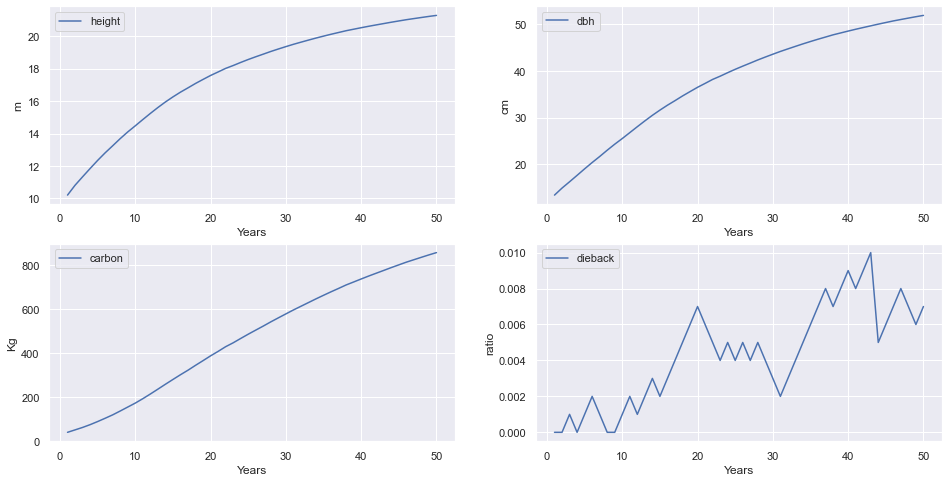

In [14]:
sns.set_theme()
fig = plt.figure(figsize=(16,8))
plt.subplot(221)
Specific_Tree.height.plot()
plt.xlabel('Years')
plt.ylabel('m')
plt.legend()
plt.subplot(222)
Specific_Tree.dbh.plot()
plt.xlabel('Years')
plt.ylabel('cm')
plt.legend()
plt.subplot(223)
Specific_Tree.carbon.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.subplot(224)
Specific_Tree.dieback.plot()
plt.xlabel('Years')
plt.ylabel('ratio')
plt.legend()
plt.show()

In [22]:
# Check leaf area indices
from src.impacts.water import *
C = Calibration(leaf_transition_days=28)
state = Specific_Tree.xs(5)
dbh = state['dbh']
th = state['height']
ch = state['crownH']
cw = state['crownW']
loss = state['dieback']
compute_leaf_area_index(dbh,th,ch,cw,loss,C.avg_shade_factor)

(30.916305593378414, 0.12255285262844401, 31.03885844600686)

In [23]:
# Using carbon estimator seperately
from src.impacts.carbon import Carbon
myCarbs = Carbon(fname_config_allometrics,'decidu')
myCarbs.compute_carbon_storage(dbh)

(89.55003087435036, 179.1000617487007)

953.4818769783853

### 3.2 Site level inspections

In [17]:
# Site level aggregate variables
df_out_site = site.datacollector.get_model_vars_dataframe()
df_out_site.tail()

,Storage,Seq,Released,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std
45,71450.994711,1705.441672,110.791747,100,0,0,0,0,54,9.865872
46,73026.399518,1575.404807,158.839089,99,1,0,0,0,54,9.247432
47,74639.025735,1595.130789,298.103995,99,1,0,0,0,55,9.531700
48,76256.979199,1603.161423,291.989958,99,1,0,0,0,56,9.711863
49,77844.394283,1572.394996,197.432631,100,0,0,0,0,57,9.571495


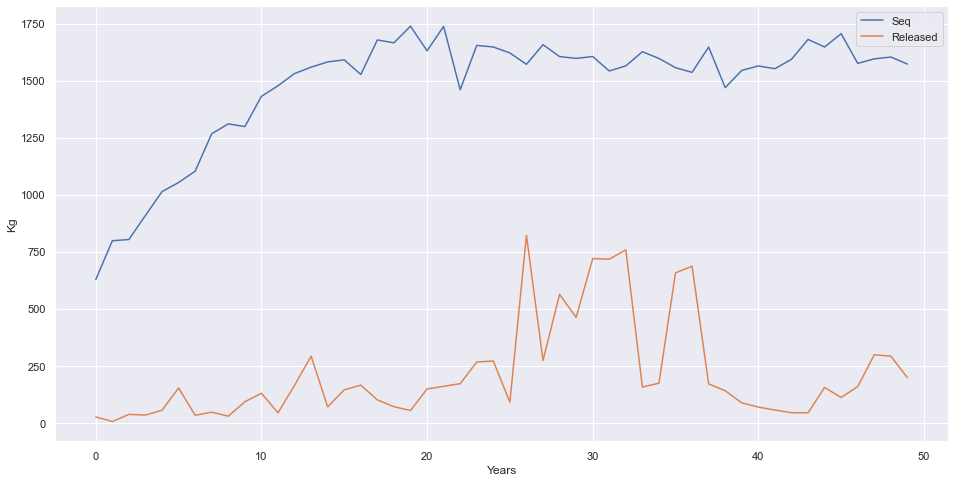

In [18]:
fig = plt.figure(figsize=(16,8))
df_out_site.Seq.plot()
df_out_site.Released.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.show()

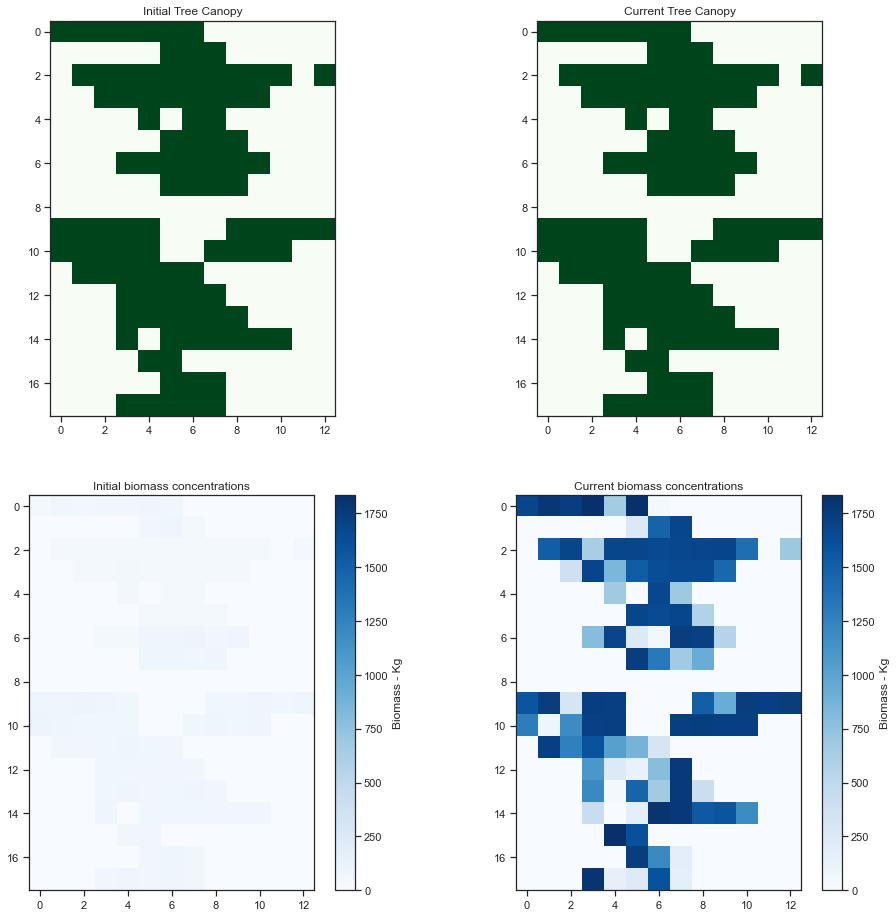

In [19]:
locations = get_raster_data(site, counts=True)
biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Initial Tree Canopy")

plt.subplot(222)
plt.imshow(locations, cmap='Greens')
plt.title("Current Tree Canopy")

plt.subplot(223)
plt.title("Initial biomass concentrations")
plt.imshow(initial_biomass, cmap='Blues', vmin=0, vmax=biomass.max())
plt.colorbar(label = 'Biomass - Kg')

plt.subplot(224)
plt.title("Current biomass concentrations")
plt.imshow(biomass, cmap='Blues')
plt.colorbar(label = 'Biomass - Kg')
plt.show()